<a href="https://colab.research.google.com/github/Sayani03/INTERNSHIP1/blob/main/Project_Final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [ ]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Dataset/FPS_Dataset.csv')
df['Month'] = pd.to_datetime(df['Month'], format='%b-%y')
df = df.sort_values('Month')
df

NameError: name 'pd' is not defined

In [ ]:
# Convert 'CMR' to numeric and impute NaN values with the median
df['CMR'] = pd.to_numeric(df['CMR'], errors='coerce')
df['CMR'] = df['CMR'].fillna(df['CMR'].median())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create lag features
for i in range(1, 13):
    df[f'last_{i}_month'] = df['CMR'].shift(i)

# Impute missing values in lag features with median
for col in df.columns:
    if 'last_' in col:
        df[col] = df[col].fillna(df[col].median())

In [ ]:
# Additional feature engineering
df['month'] = df['Month'].dt.month
df['quarter'] = df['Month'].dt.quarter
df['year'] = df['Month'].dt.year

# Drop initial rows with NaN values due to lag features
df = df.dropna()

# Split the data into train (2018-2022) and test (2023)
train_data = df[df['Month'].dt.year <= 2022]
test_data = df[df['Month'].dt.year == 2023]

# Prepare training and testing sets
X_train = train_data.drop(['Month', 'CMR'], axis=1)
y_train = train_data['CMR']
X_test = test_data.drop(['Month', 'CMR'], axis=1)
y_test = test_data['CMR']

In [ ]:
#xgboost model
# Hyperparameter tuning (optional, XGBoost generally requires less tuning)
params = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(**params)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Combine train and test predictions
predictions = np.concatenate([train_pred, test_pred])

# Create a dataframe with actual and predicted values
results = pd.DataFrame({
    'Month': pd.concat([train_data['Month'], test_data['Month']]).reset_index(drop=True),
    'Actual': pd.concat([train_data['CMR'], test_data['CMR']]).reset_index(drop=True),
    'XGBoost_Prediction': predictions
})


In [ ]:
#CatBoost Model
# Train the final model with the best parameters
best_params = {'depth': 5, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.2}
final_cb = CatBoostRegressor(**best_params, random_state=42, silent=True)
final_cb.fit(X_train, y_train)

# Make predictions
train_pred = final_cb.predict(X_train)
test_pred = final_cb.predict(X_test)

# Combine train and test predictions
predictions = np.concatenate([train_pred, test_pred])

# Create a dataframe with actual and predicted values
results = pd.DataFrame({
    'Month': pd.concat([train_data['Month'], test_data['Month']]).reset_index(drop=True),
    'Actual': pd.concat([train_data['CMR'], test_data['CMR']]).reset_index(drop=True),
    'CatBoost': predictions
})


In [ ]:
#Svm model
# Train the SVR model with chosen parameters
kernel = 'rbf'  # You can change this to 'linear', 'poly', or 'sigmoid'
C = 10000  # You can adjust the value of C as needed
svr_model = SVR(kernel=kernel, C=C)
svr_model.fit(X_train, y_train)

# Make predictions
train_pred = svr_model.predict(X_train)
test_pred = svr_model.predict(X_test)

# Combine train and test predictions
predictions = np.concatenate([train_pred, test_pred])

# Create a dataframe with actual and predicted values
results = pd.DataFrame({
    'Month': pd.concat([train_data['Month'], test_data['Month']]).reset_index(drop=True),
    'Actual': pd.concat([train_data['CMR'], test_data['CMR']]).reset_index(drop=True),
    'SVR_Prediction': predictions
})


In [ ]:
#Random forest
# Hyperparameter tuning (optional)
params = {
    'n_estimators': 100,
    'max_depth': 10,
    'random_state': 42
}

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(**params)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_test)

# Combine train and test predictions
predictions = np.concatenate([train_pred, test_pred])

# Create a dataframe with actual and predicted values
results = pd.DataFrame({
    'Month': pd.concat([train_data['Month'], test_data['Month']]).reset_index(drop=True),
    'Actual': pd.concat([train_data['CMR'], test_data['CMR']]).reset_index(drop=True),
    'RandomForest_Prediction': predictions
})


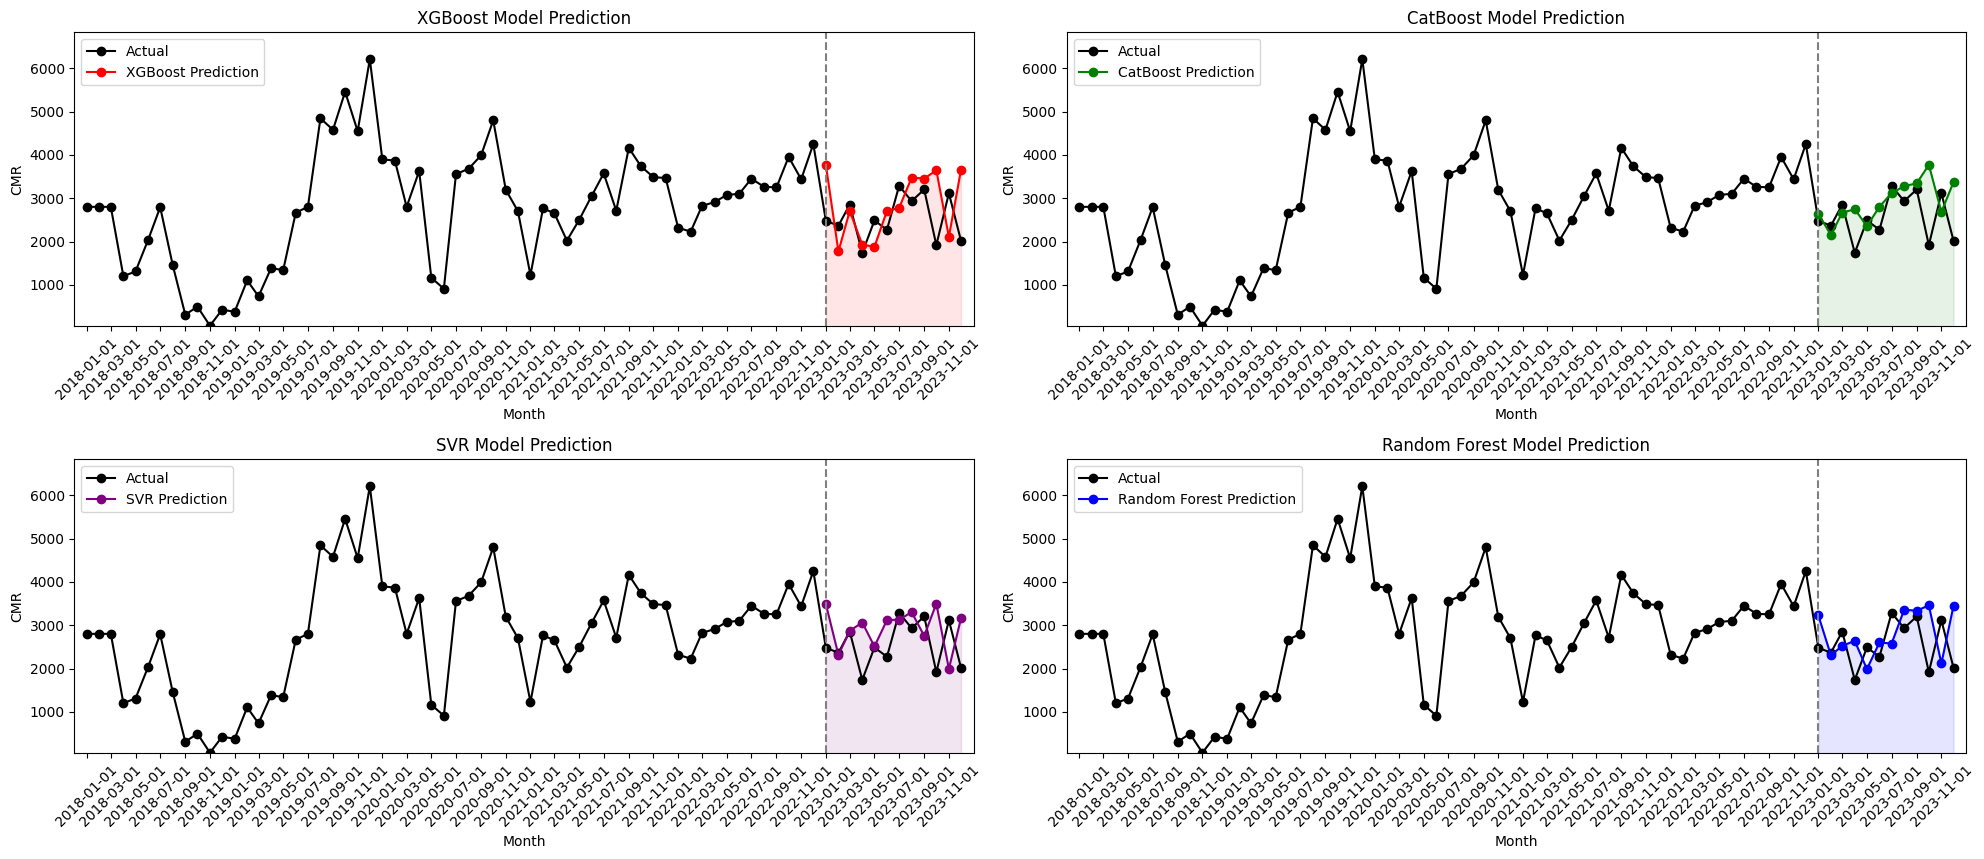

XGBoost Model Performance:
Mean Absolute Percentage Error (MAPE): 6.210%
Root Mean Squared Error (RMSE): 371.93
R² Score: 0.91
Mean Absolute Error (MAE): 132.13

CatBoost Model Performance:
Mean Absolute Percentage Error (MAPE): 4.778%
Root Mean Squared Error (RMSE): 313.11
R² Score: 0.94
Mean Absolute Error (MAE): 97.69

SVR Model Performance:
Mean Absolute Percentage Error (MAPE): 15.730%
Root Mean Squared Error (RMSE): 443.95
R² Score: 0.87
Mean Absolute Error (MAE): 205.48

Random Forest Model Performance:
Mean Absolute Percentage Error (MAPE): 23.227%
Root Mean Squared Error (RMSE): 463.14
R² Score: 0.86
Mean Absolute Error (MAE): 334.13



In [ ]:
# results for all models are combined into one DataFrame
results = pd.DataFrame({
    'Month': pd.concat([train_data['Month'], test_data['Month']]).reset_index(drop=True),
    'Actual': pd.concat([train_data['CMR'], test_data['CMR']]).reset_index(drop=True),
    'XGBoost_Prediction': xgb_model.predict(pd.concat([X_train, X_test])),
    'CatBoost_Prediction': final_cb.predict(pd.concat([X_train, X_test])),
    'SVR_Prediction': svr_model.predict(pd.concat([X_train, X_test])),
    'RandomForest_Prediction': rf_model.predict(pd.concat([X_train, X_test]))
})

# Visualization for all models
plt.figure(figsize=(20, 12))

# Models to visualize
models = ['XGBoost_Prediction', 'CatBoost_Prediction', 'SVR_Prediction', 'RandomForest_Prediction']
model_names = ['XGBoost', 'CatBoost', 'SVR', 'Random Forest']
colors = ['red', 'green', 'purple', 'blue']

for i, (model, name, color) in enumerate(zip(models, model_names, colors)):
    plt.subplot(3, 2, i + 1)

    # Plot the actual data
    plt.plot(results['Month'], results['Actual'], marker='o', linestyle='-', color='black', label='Actual')

    # Plot the model predictions
    results_filtered = results[(results['Month'] >= '2023-01-01')]
    plt.plot(results_filtered['Month'], results_filtered[model], marker='o', linestyle='-', color=color, label=f'{name} Prediction')

    # Add a vertical line to separate train and test data
    plt.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--')

    # Fill the area between the model predictions and the horizontal axis
    plt.fill_between(results_filtered['Month'], results_filtered[model], color=color, alpha=0.1)

    # Add title and labels
    plt.title(f'{name} Model Prediction')
    plt.xlabel('Month')
    plt.ylabel('CMR')

    # Format the x-axis with date ticks
    plt.xticks(pd.date_range(start=df['Month'].min(), end=df['Month'].max(), freq='2MS').to_pydatetime(), rotation=45)

    # Set x-axis and y-axis limits
    plt.xlim(df['Month'].min() - pd.DateOffset(months=1), df['Month'].max() + pd.DateOffset(months=1))
    plt.ylim(results['Actual'].min() * 0.9, results['Actual'].max() * 1.1)

    # Add legend
    plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Calculate and print model performance metrics for each model
for model, name in zip(models, model_names):
    mape = mean_absolute_percentage_error(results['Actual'], results[model])*100
    rmse = mean_squared_error(results['Actual'],results[model],squared=False)
    r2 = r2_score(results['Actual'], results[model])
    mae = mean_absolute_error(results['Actual'], results[model])

    print(f"{name} Model Performance:")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}\n")


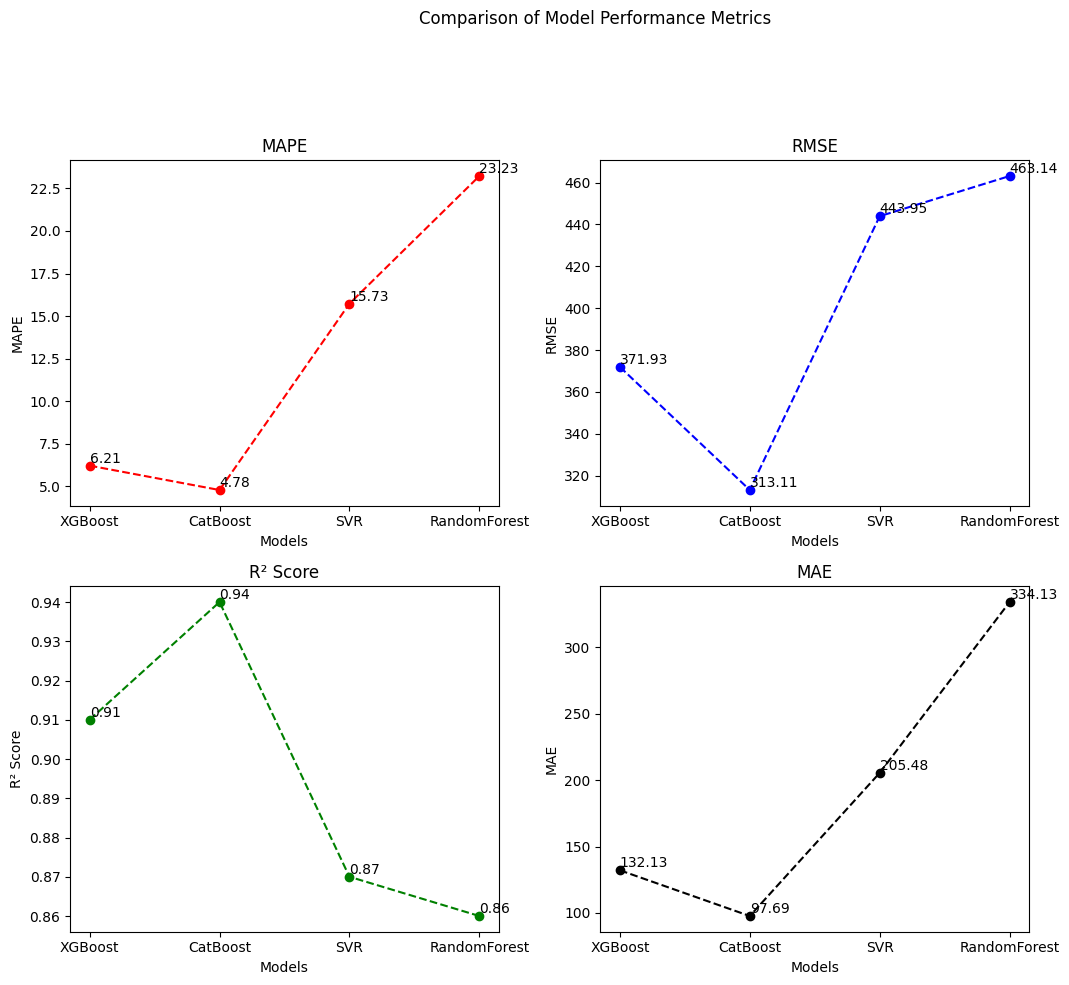

In [ ]:
import matplotlib.pyplot as plt

# Values for
mape_values = [6.210, 4.778, 15.730, 23.227]
rmse_values = [371.93, 313.11, 443.95, 463.14]
r2_values = [0.91, 0.94, 0.87, 0.86]
mae_values = [132.13, 97.69, 205.48, 334.13]
labels = ['XGBoost', 'CatBoost', 'SVR', 'RandomForest']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Comparison of Model Performance Metrics')

# Plot MAPE
axes[0, 0].plot(labels, mape_values, marker='o', linestyle='--', color='red')
axes[0, 0].set_title('MAPE')
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('MAPE')
for label, value in zip(labels, mape_values):
    axes[0, 0].text(label, value, f'{value:.2f}', ha='left', va='bottom')

# Plot RMSE
axes[0, 1].plot(labels, rmse_values, marker='o', linestyle='--', color='blue')
axes[0, 1].set_title('RMSE')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('RMSE')
for label, value in zip(labels, rmse_values):
    axes[0, 1].text(label, value, f'{value:.2f}', ha='left', va='bottom')

# Plot R² Score
axes[1, 0].plot(labels, r2_values, marker='o', linestyle='--', color='green')
axes[1, 0].set_title('R² Score')
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('R² Score')
for label, value in zip(labels, r2_values):
    axes[1, 0].text(label, value, f'{value:.2f}', ha='left', va='bottom')

# Plot MAE
axes[1, 1].plot(labels, mae_values, marker='o', linestyle='--', color='black')
axes[1, 1].set_title('MAE')
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('MAE')
for label, value in zip(labels, mae_values):
    axes[1, 1].text(label, value, f'{value:.2f}', ha='left', va='bottom')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 0.9])
plt.show()


        Month  CatBoost_Prediction
0  2024-01-01          2944.195842
1  2024-02-01          2944.195842
2  2024-03-01          2944.195842
3  2024-04-01          2512.720838
4  2024-05-01          2076.471147
5  2024-06-01          2590.553224
6  2024-07-01          3196.282315
7  2024-08-01          2853.351548
8  2024-09-01          2054.687409
9  2024-10-01          1839.753594
10 2024-11-01          1502.786098
11 2024-12-01          1977.062542


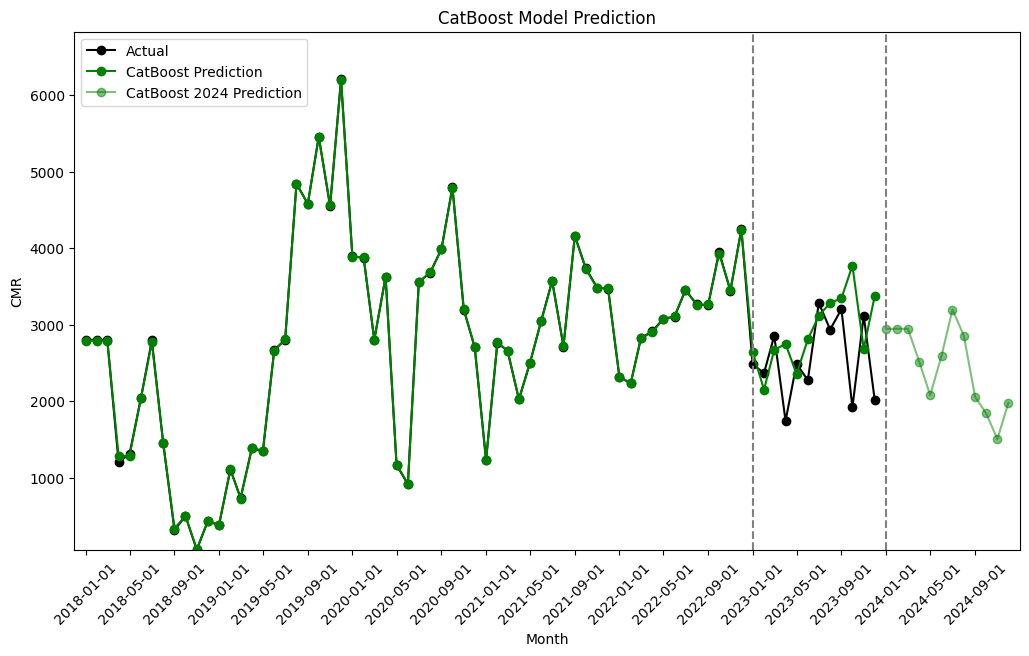

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = pd.DataFrame({
    'Month': pd.concat([train_data['Month'], test_data['Month']]).reset_index(drop=True),
    'Actual': pd.concat([train_data['CMR'], test_data['CMR']]).reset_index(drop=True),
    'CatBoost_Prediction': final_cb.predict(pd.concat([X_train, X_test])),
})

# Predicting for year 2024
dates_2024 = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')
X_2024 = pd.DataFrame({'Month': dates_2024})
for i in range(1, 13):
    X_2024[f'last_{i}_month'] = df['CMR'].shift(i).fillna(df['CMR'].median())

# Additional feature engineering for 2024
X_2024['month'] = X_2024['Month'].dt.month
X_2024['quarter'] = X_2024['Month'].dt.quarter
X_2024['year'] = X_2024['Month'].dt.year

# Remove rows with NaN values due to lag features
X_2024 = X_2024.dropna()

# Predict using the models
results_2024 = pd.DataFrame({'Month': dates_2024})
results_2024['CatBoost_Prediction'] = final_cb.predict(X_2024.drop('Month', axis=1))

print(results_2024)

# Visualization for all models
plt.figure(figsize=(20, 12))

# Models to visualize
models = ['CatBoost_Prediction']
model_names = ['CatBoost']
colors = ['green']

for i, (model, name, color) in enumerate(zip(models, model_names, colors)):
    plt.subplot(2, 2, i + 1)

    # Plot the actual data
    plt.plot(results['Month'], results['Actual'], marker='o', linestyle='-', color='black', label='Actual')

    # Plot the model predictions for training and test data
    plt.plot(results['Month'], results[model], marker='o', linestyle='-', color=color, label=f'{name} Prediction')

    # Plot the model predictions for 2024
    plt.plot(results_2024['Month'], results_2024[model], marker='o', linestyle='-', color=color, alpha=0.5, label=f'{name} 2024 Prediction')

    # Add a vertical line to separate train and test data
    plt.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--')

    # Add a vertical line to indicate 2024
    plt.axvline(x=pd.Timestamp('2024-01-01'), color='gray', linestyle='--')

    # Add title and labels
    plt.title(f'{name} Model Prediction')
    plt.xlabel('Month')
    plt.ylabel('CMR')

    # Format the x-axis with date ticks
    plt.xticks(pd.date_range(start=df['Month'].min(), end=dates_2024.max(), freq='4MS').to_pydatetime(), rotation=45)

    # Set x-axis and y-axis limits
    plt.xlim(df['Month'].min() - pd.DateOffset(months=1), dates_2024.max() + pd.DateOffset(months=1))
    plt.ylim(results['Actual'].min() * 0.9, results['Actual'].max() * 1.1)

    # Add legend
    plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()



        Month  XGBoost_Prediction
0  2024-01-01         2610.451172
1  2024-02-01         2655.892090
2  2024-03-01         2649.979248
3  2024-04-01         1816.304443
4  2024-05-01         1437.822388
5  2024-06-01         2285.085938
6  2024-07-01         2934.405029
7  2024-08-01         2326.328857
8  2024-09-01          820.493347
9  2024-10-01         1005.486145
10 2024-11-01          556.639221
11 2024-12-01          866.121887


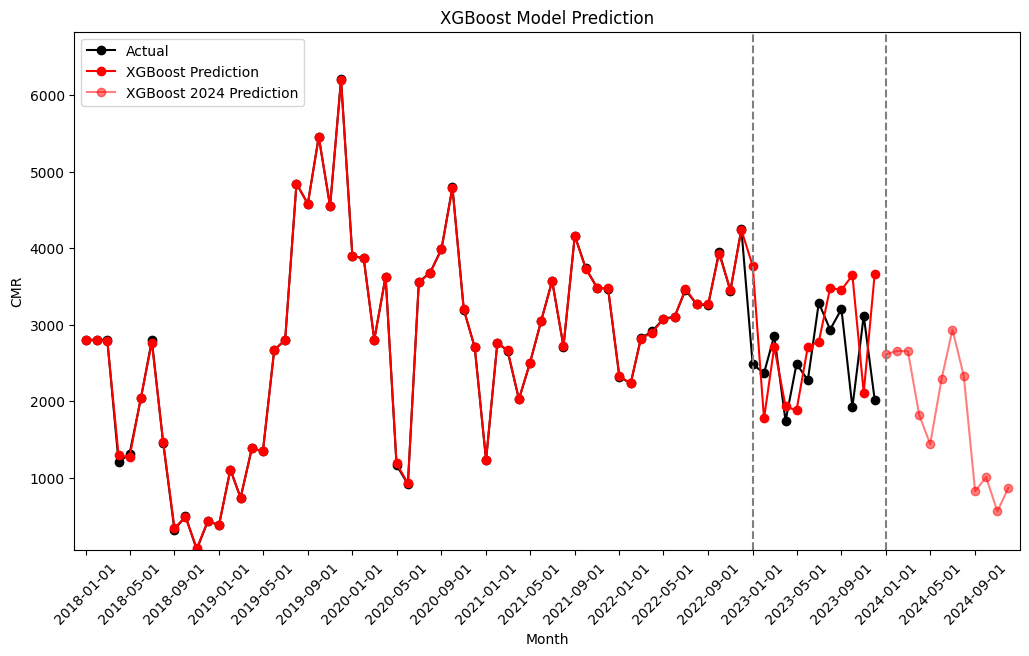

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = pd.DataFrame({
    'Month': pd.concat([train_data['Month'], test_data['Month']]).reset_index(drop=True),
    'Actual': pd.concat([train_data['CMR'], test_data['CMR']]).reset_index(drop=True),
    'XGBoost_Prediction': xgb_model.predict(pd.concat([X_train, X_test])),
})

# Predicting for year 2024
dates_2024 = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')
X_2024 = pd.DataFrame({'Month': dates_2024})
for i in range(1, 13):
    X_2024[f'last_{i}_month'] = df['CMR'].shift(i).fillna(df['CMR'].median())

# Additional feature engineering for 2024
X_2024['month'] = X_2024['Month'].dt.month
X_2024['quarter'] = X_2024['Month'].dt.quarter
X_2024['year'] = X_2024['Month'].dt.year

# Remove rows with NaN values due to lag features
X_2024 = X_2024.dropna()

# Predict using the models
results_2024 = pd.DataFrame({'Month': dates_2024})
results_2024['XGBoost_Prediction'] =xgb_model.predict(X_2024.drop('Month', axis=1))

print(results_2024)

# Visualization for all models
plt.figure(figsize=(20, 12))

# Models to visualize
models = ['XGBoost_Prediction']
model_names = ['XGBoost']
colors = ['red']

for i, (model, name, color) in enumerate(zip(models, model_names, colors)):
    plt.subplot(2, 2, i + 1)

    # Plot the actual data
    plt.plot(results['Month'], results['Actual'], marker='o', linestyle='-', color='black', label='Actual')

    # Plot the model predictions for training and test data
    plt.plot(results['Month'], results[model], marker='o', linestyle='-', color=color, label=f'{name} Prediction')

    # Plot the model predictions for 2024
    plt.plot(results_2024['Month'], results_2024[model], marker='o', linestyle='-', color=color, alpha=0.5, label=f'{name} 2024 Prediction')

    # Add a vertical line to separate train and test data
    plt.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--')

    # Add a vertical line to indicate 2024
    plt.axvline(x=pd.Timestamp('2024-01-01'), color='gray', linestyle='--')

    # Add title and labels
    plt.title(f'{name} Model Prediction')
    plt.xlabel('Month')
    plt.ylabel('CMR')

    # Format the x-axis with date ticks
    plt.xticks(pd.date_range(start=df['Month'].min(), end=dates_2024.max(), freq='4MS').to_pydatetime(), rotation=45)

    # Set x-axis and y-axis limits
    plt.xlim(df['Month'].min() - pd.DateOffset(months=1), dates_2024.max() + pd.DateOffset(months=1))
    plt.ylim(results['Actual'].min() * 0.9, results['Actual'].max() * 1.1)

    # Add legend
    plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()



        Month  CatBoost_Prediction
0  2024-01-01          2639.742013
1  2024-02-01          2149.835279
2  2024-03-01          2668.384689
3  2024-04-01          2745.407286
4  2024-05-01          2355.039350
5  2024-06-01          2805.007778
6  2024-07-01          3116.651382
7  2024-08-01          3280.203534
8  2024-09-01          3342.368549
9  2024-10-01          3770.776377
10 2024-11-01          2684.111120
11 2024-12-01          3371.539017


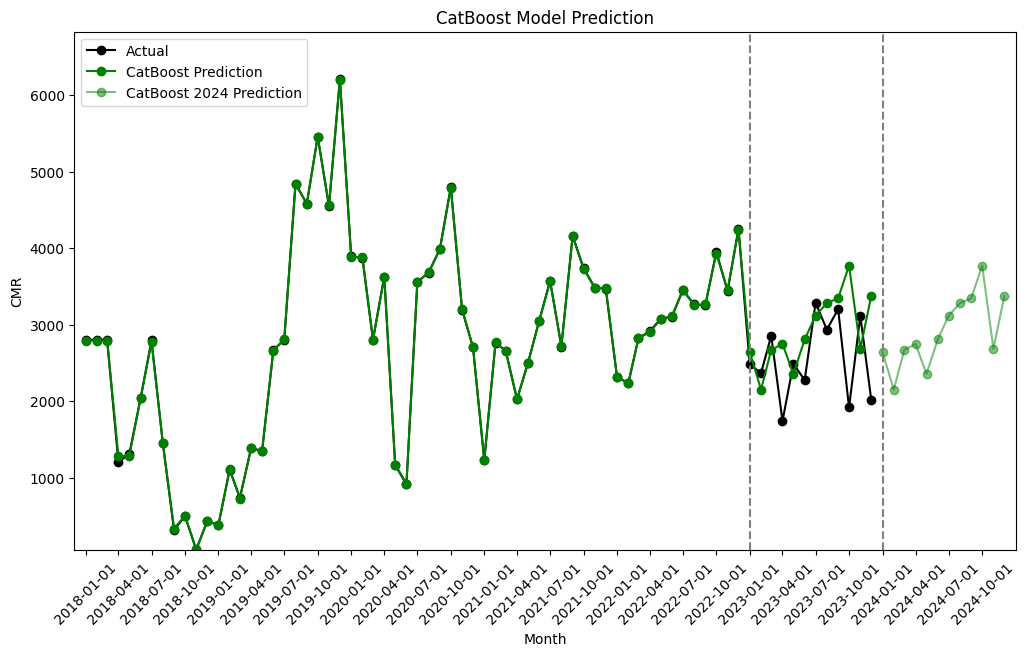

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Combining train and test data for complete dataset
df_combined = pd.concat([train_data, test_data]).reset_index(drop=True)

# Create the results DataFrame for train and test data
results = pd.DataFrame({
    'Month': df_combined['Month'],
    'Actual': df_combined['CMR'],
    'CatBoost_Prediction': final_cb.predict(pd.concat([X_train, X_test])),
})

# Predicting for year 2024
dates_2024 = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')
X_2024 = pd.DataFrame({'Month': dates_2024})

# Creating lag features for 2024 predictions
for i in range(1, 13):
    X_2024[f'last_{i}_month'] = df_combined['CMR'].shift(i).fillna(df_combined['CMR'].median()).iloc[-12:].reset_index(drop=True)

# Additional feature engineering for 2024
X_2024['month'] = X_2024['Month'].dt.month
X_2024['quarter'] = X_2024['Month'].dt.quarter
X_2024['year'] = X_2024['Month'].dt.year

# Predict using the model
results_2024 = pd.DataFrame({'Month': dates_2024})
results_2024['CatBoost_Prediction'] = final_cb.predict(X_2024.drop('Month', axis=1))

print(results_2024)

# Visualization for all models
plt.figure(figsize=(20, 12))

# Models to visualize
models = ['CatBoost_Prediction']
model_names = ['CatBoost']
colors = ['green']

for i, (model, name, color) in enumerate(zip(models, model_names, colors)):
    plt.subplot(2, 2, i + 1)

    # Plot the actual data
    plt.plot(results['Month'], results['Actual'], marker='o', linestyle='-', color='black', label='Actual')

    # Plot the model predictions for training and test data
    plt.plot(results['Month'], results[model], marker='o', linestyle='-', color=color, label=f'{name} Prediction')

    # Plot the model predictions for 2024
    plt.plot(results_2024['Month'], results_2024[model], marker='o', linestyle='-', color=color, alpha=0.5, label=f'{name} 2024 Prediction')

    # Add a vertical line to separate train and test data
    plt.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--')

    # Add a vertical line to indicate 2024
    plt.axvline(x=pd.Timestamp('2024-01-01'), color='gray', linestyle='--')

    # Add title and labels
    plt.title(f'{name} Model Prediction')
    plt.xlabel('Month')
    plt.ylabel('CMR')

    # Format the x-axis with date ticks
    plt.xticks(pd.date_range(start=df_combined['Month'].min(), end=dates_2024.max(), freq='3MS').to_pydatetime(), rotation=45)

    # Set x-axis and y-axis limits
    plt.xlim(df_combined['Month'].min() - pd.DateOffset(months=1), dates_2024.max() + pd.DateOffset(months=1))
    plt.ylim(results['Actual'].min() * 0.9, results['Actual'].max() * 1.1)

    # Add legend
    plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


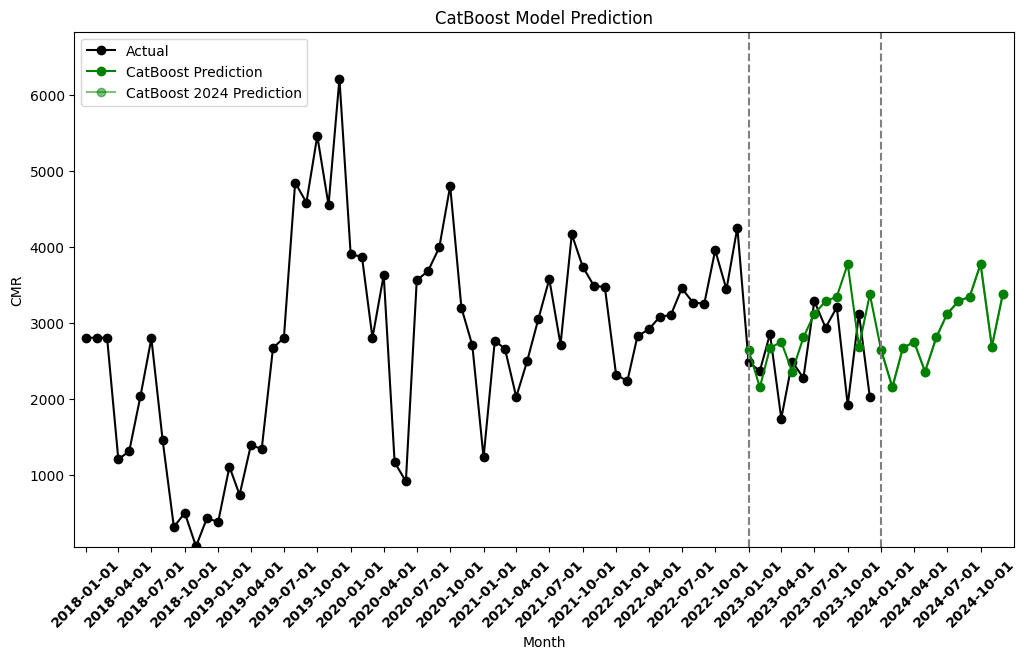

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Combine train and test data for a complete dataset
df_combined = pd.concat([train_data, test_data]).reset_index(drop=True)

# Create the results DataFrame for train and test data
results = pd.DataFrame({
    'Month': df_combined['Month'],
    'Actual': df_combined['CMR'],
    'CatBoost_Prediction': final_cb.predict(pd.concat([X_train, X_test]))
})

# Predicting for the year 2024
dates_2024 = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')
X_2024 = pd.DataFrame({'Month': dates_2024})

# Creating lag features for 2024 predictions
for i in range(1, 13):
    X_2024[f'last_{i}_month'] = df_combined['CMR'].shift(i).fillna(df_combined['CMR'].median()).iloc[-12:].reset_index(drop=True)

# Additional feature engineering for 2024
X_2024['month'] = X_2024['Month'].dt.month
X_2024['quarter'] = X_2024['Month'].dt.quarter
X_2024['year'] = X_2024['Month'].dt.year

# Predict using the models
results_2024 = pd.DataFrame({'Month': dates_2024})
results_2024['CatBoost_Prediction'] = final_cb.predict(X_2024.drop('Month', axis=1))

# Filter results to exclude predictions before 2023
results['CatBoost_Prediction'] = np.where(results['Month'] >= '2023-01-01', results['CatBoost_Prediction'], np.nan)

# Concatenate the 2024 predictions to the results to ensure continuity
results = pd.concat([results, results_2024], ignore_index=True)

# Visualization for all models
plt.figure(figsize=(20, 12))

# Models to visualize
models = ['CatBoost_Prediction']
model_names = ['CatBoost']
colors = ['green']

for i, (model, name, color) in enumerate(zip(models, model_names, colors)):
    plt.subplot(2, 2, i + 1)

    # Plot the actual data
    plt.plot(results['Month'], results['Actual'], marker='o', linestyle='-', color='black', label='Actual')

    # Plot the model predictions for training and test data from 2023 onwards
    plt.plot(results['Month'], results[model], marker='o', linestyle='-', color=color, label=f'{name} Prediction')

    # Plot the model predictions for 2024
    plt.plot(results_2024['Month'], results_2024[model], marker='o', linestyle='-', color=color, alpha=0.5, label=f'{name} 2024 Prediction')

    # Add a vertical line to separate train and test data
    plt.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--')

    # Add a vertical line to indicate 2024
    plt.axvline(x=pd.Timestamp('2024-01-01'), color='gray', linestyle='--')

    # Add title and labels
    plt.title(f'{name} Model Prediction')
    plt.xlabel('Month')
    plt.ylabel('CMR')

    # Format the x-axis with date ticks
    plt.xticks(pd.date_range(start=df_combined['Month'].min(), end=dates_2024.max(), freq='3MS').to_pydatetime(), rotation=45, fontweight='bold')

    # Set x-axis and y-axis limits
    plt.xlim(df_combined['Month'].min() - pd.DateOffset(months=1), dates_2024.max() + pd.DateOffset(months=1))
    plt.ylim(results['Actual'].min() * 0.9, results['Actual'].max() * 1.1)

    # Add legend
    plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


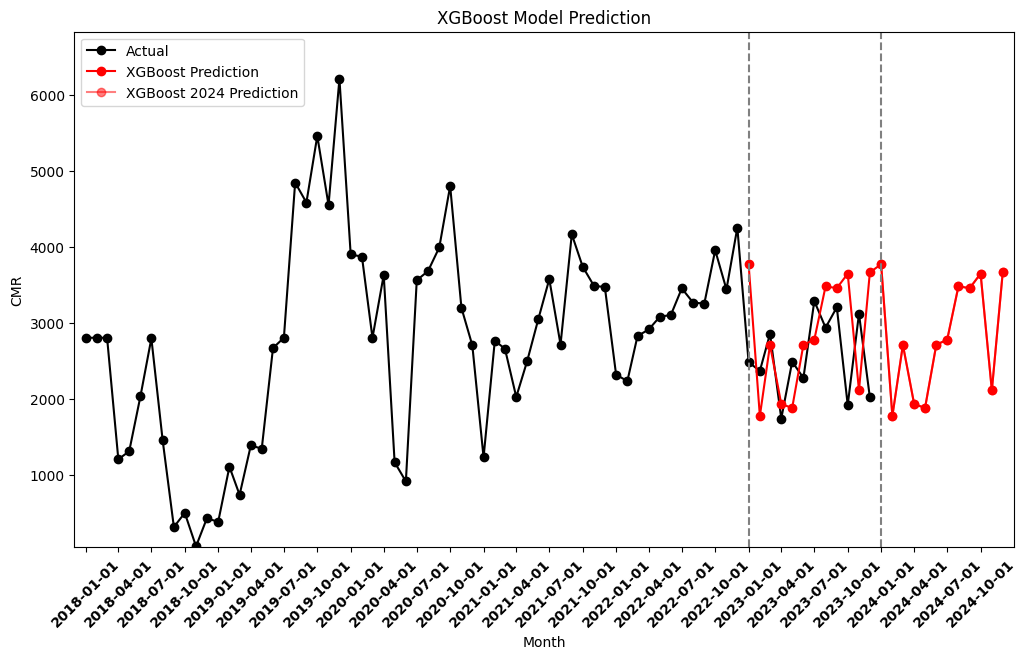

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Combine train and test data for complete dataset
df_combined = pd.concat([train_data, test_data]).reset_index(drop=True)

# Create the results DataFrame for train and test data
results = pd.DataFrame({
    'Month': df_combined['Month'],
    'Actual': df_combined['CMR'],
    'XGBoost_Prediction': xgb_model.predict(pd.concat([X_train, X_test])),
})

# Predicting for year 2024
dates_2024 = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')
X_2024 = pd.DataFrame({'Month': dates_2024})

# Creating lag features for 2024 predictions
for i in range(1, 13):
    X_2024[f'last_{i}_month'] = df_combined['CMR'].shift(i).fillna(df_combined['CMR'].median()).iloc[-12:].reset_index(drop=True)

# Additional feature engineering for 2024
X_2024['month'] = X_2024['Month'].dt.month
X_2024['quarter'] = X_2024['Month'].dt.quarter
X_2024['year'] = X_2024['Month'].dt.year

# Remove rows with NaN values due to lag features
X_2024 = X_2024.dropna()

# Predict using the models
results_2024 = pd.DataFrame({'Month': dates_2024})
results_2024['XGBoost_Prediction'] = xgb_model.predict(X_2024.drop('Month', axis=1))

# Filter results to exclude predictions before 2023
results['XGBoost_Prediction'] = np.where(results['Month'] >= '2023-01-01', results['XGBoost_Prediction'], np.nan)

# Concatenate the 2024 predictions to the results to ensure continuity
results = pd.concat([results, results_2024], ignore_index=True)

# Visualization for all models
plt.figure(figsize=(20, 12))

# Models to visualize
models = ['XGBoost_Prediction']
model_names = ['XGBoost']
colors = ['red']

for i, (model, name, color) in enumerate(zip(models, model_names, colors)):
    plt.subplot(2, 2, i + 1)

    # Plot the actual data
    plt.plot(results['Month'], results['Actual'], marker='o', linestyle='-', color='black', label='Actual')

    # Plot the model predictions for training and test data from 2023 onwards
    plt.plot(results['Month'], results[model], marker='o', linestyle='-', color=color, label=f'{name} Prediction')

    # Plot the model predictions for 2024
    plt.plot(results_2024['Month'], results_2024[model], marker='o', linestyle='-', color=color, alpha=0.5, label=f'{name} 2024 Prediction')

    # Add a vertical line to separate train and test data
    plt.axvline(x=pd.Timestamp('2023-01-01'), color='gray', linestyle='--')

    # Add a vertical line to indicate 2024
    plt.axvline(x=pd.Timestamp('2024-01-01'), color='gray', linestyle='--')

    # Add title and labels
    plt.title(f'{name} Model Prediction')
    plt.xlabel('Month')
    plt.ylabel('CMR')

    # Format the x-axis with date ticks
    plt.xticks(pd.date_range(start=df_combined['Month'].min(), end=dates_2024.max(), freq='3MS').to_pydatetime(), rotation=45, fontweight='bold')

    # Set x-axis and y-axis limits
    plt.xlim(df_combined['Month'].min() - pd.DateOffset(months=1), dates_2024.max() + pd.DateOffset(months=1))
    plt.ylim(results['Actual'].min() * 0.9, results['Actual'].max() * 1.1)

    # Add legend
    plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()
